In [1]:
# %load test_windef.py
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""

import matplotlib.pyplot as plt

import numpy as np
import openpiv.windef as windef
from test_process import create_pair, shift_u, shift_v, threshold
from openpiv.pyprocess import get_coordinates, extended_search_area_piv, get_field_shape
from openpiv import validation, filters
import scipy.ndimage as scn
# from openpiv.windef import frame_interpolation

from scipy.interpolate import RectBivariateSpline

In [2]:
frame_a, frame_b = create_pair(image_size=256)

# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

In [3]:
# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size=64,
        overlap=32,
        iterations=1,
        correlation_method="circular",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    # print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold

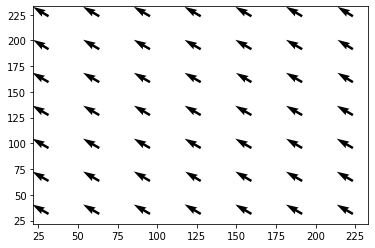

In [4]:
test_first_pass_circ()

In [5]:
def test_multi_pass_circ():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size[0],
        overlap[0],
        iterations,
        correlation_method="circular",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    u_old = u.copy()
    v_old = v.copy()
    plt.figure()
    plt.quiver(x,y,u,v,color='r')
    
    for i in range(2, iterations + 1):
        x, y, u, v, s2n, mask = windef.multipass_img_deform(
            frame_a,
            frame_b,
            window_size[i - 1],
            overlap[i - 1],
            iterations,
            i,
            x,
            y,
            u,
            v,
            correlation_method="circular",
            subpixel_method="gaussian",
            do_sig2noise=False,
            sig2noise_method="peak2peak",
            sig2noise_mask=2,
            MinMaxU=(-100, 50),
            MinMaxV=(-50, 50),
            std_threshold=1000000,
            median_threshold=200000,
            median_size=1,
            filter_method="localmean",
            max_filter_iteration=10,
            filter_kernel_size=2,
            interpolation_order=3,
        )
        plt.figure()
        plt.quiver(x,y,u,v,color='b')

    # print("\n", x, y, u, v, s2n)
    
    assert np.mean(np.abs(u - shift_u)) < threshold and np.any(u != u_old)
    assert np.mean(np.abs(v - shift_v)) < threshold and np.any(v != v_old)
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.

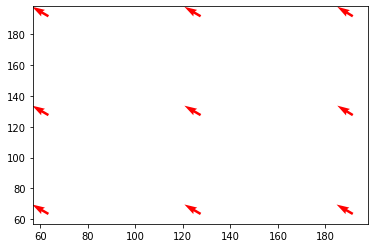

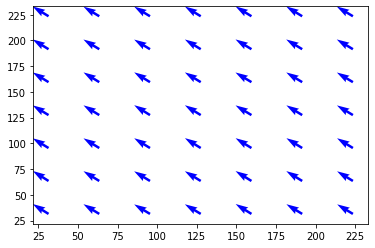

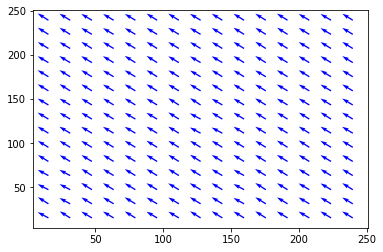

In [6]:
test_multi_pass_circ()

In [7]:
# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size=64,
        overlap=32,
        iterations=1,
        correlation_method="linear",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_multi_pass_lin():
    """ test fot the multipass """
    window_size = (128, 64, 32)
    overlap = (64, 32, 16)
    iterations = 3

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        window_size[0],
        overlap[0],
        iterations,
        correlation_method="linear",
        subpixel_method="gaussian",
        do_sig2noise=True,
        sig2noise_method="peak2peak",
        sig2noise_mask=2,
    )
    u_old = u.copy()
    v_old = v.copy()
    i = 1
    for i in range(2, iterations + 1):
        x, y, u, v, sn, m = windef.multipass_img_deform(
            frame_a,
            frame_b,
            window_size[i - 1],
            overlap[i - 1],
            iterations,
            i,
            x,
            y,
            u,
            v,
            correlation_method="linear",
            subpixel_method="gaussian",
            do_sig2noise=False,
            sig2noise_method="peak2peak",
            sig2noise_mask=2,
            MinMaxU=(-100, 50),
            MinMaxV=(-50, 50),
            std_threshold=1000000,
            median_threshold=200000,
            median_size=1,
            filter_method="localmean",
            max_filter_iteration=10,
            filter_kernel_size=2,
            interpolation_order=3,
        )

    print("\n", x, y, u, v, s2n)
    plt.quiver(x,y,u,v)
    assert np.max(np.abs(u - shift_u)) < threshold and np.any(u != u_old)
    assert np.max(np.abs(v - shift_v)) < threshold and np.any(v != v_old)

    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


 [[ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]
 [ 31.5  63.5  95.5 127.5 159.5 191.5 223.5]] [[ 31.5  31.5  31.5  31.5  31.5  31.5  31.5]
 [ 63.5  63.5  63.5  63.5  63.5  63.5  63.5]
 [ 95.5  95.5  95.5  95.5  95.5  95.5  95.5]
 [127.5 127.5 127.5 127.5 127.5 127.5 127.5]
 [159.5 159.5 159.5 159.5 159.5 159.5 159.5]
 [191.5 191.5 191.5 191.5 191.5 191.5 191.5]
 [223.5 223.5 223.5 223.5 223.5 223.5 223.5]] [[-5.62150081 -5.63118854 -5.62711791 -5.61035926 -5.60842178 -5.64271644
  -5.6286937 ]
 [-5.61766025 -5.64184492 -5.62928086 -5.37469241 -5.61659489 -5.63686507
  -5.63101431]
 [-5.6254699  -5.65763585 -5.62191295 -5.61393824 -5.61914938 -5.60429813
  -5.64055421]
 [-5.62509928 -5.60967399 -5.59611104 -5.6095403  -5.64228957 -5.60900026
  -5.60216998]
 [-5.62244

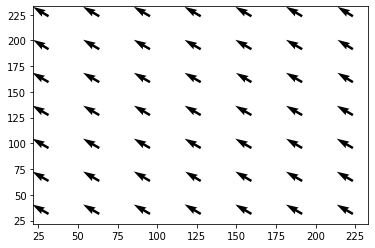

In [8]:
test_first_pass_lin()